# Задача обнаружения
(cv_detection)=

In [2]:
import os

import numpy as np
from matplotlib import pyplot as plt
import cv2

image_folder = os.path.join("..", "..", "_static", "lecture_specific", "cv")

def show_image(ax, image, title=None, cmap=None):
    """
    Вывести изображение в указанных осях.
    """
    ax.imshow(image, cmap=cmap)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

Поставим задачу автоматического обнаружения монет.

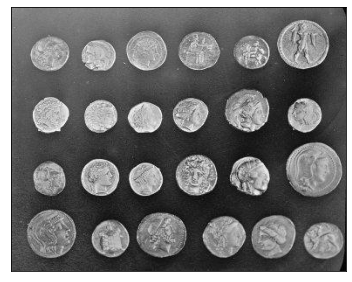

In [3]:
path = os.path.join(image_folder, "coins.jpg")
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(figsize=(5, 5), layout="tight")
show_image(ax, image, cmap="gray")

## Обнаружение круглых контуров

[Преобразование Хафа](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A5%D0%B0%D1%84%D0%B0) позволяет искать на изображении прямые, окружности, эллипсы и некоторые другие параметрические геометрических элементов.

Так, например, метод [cv2.HoughCircles](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d) позволяет искать окружности, что может пригодиться в нашей задаче, т.к. монеты имеют округлую форму.

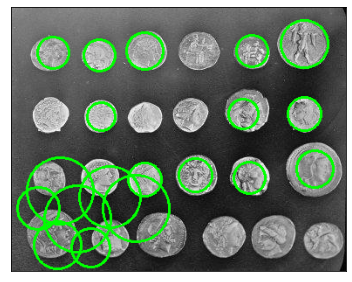

In [15]:
circles = cv2.HoughCircles(image, method=cv2.HOUGH_GRADIENT, dp=2.5, minDist=30, minRadius=10, maxRadius=40)
circles = circles.astype(int).reshape(-1, 3)

green_color = (0, 255, 0)
linewidth = 2
detected_circles = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
for (x, y, r) in circles:
    cv2.circle(detected_circles, (int(x), int(y)), int(r), green_color, linewidth)

fig, ax = plt.subplots(figsize=(5, 5), layout="tight")
show_image(ax, detected_circles, cmap="gray")

Предварительной обработкой изображения и настройкой параметров метода можно значительно повлиять на качество распознавания окружностей. 

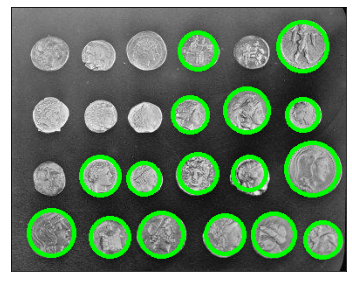

In [5]:
blured = cv2.GaussianBlur(image, (9, 9), 0)
blured_canny = cv2.Canny(blured, 100, 180)
circles = cv2.HoughCircles(blured_canny, method=cv2.HOUGH_GRADIENT, dp=2.8, minDist=30, minRadius=10, maxRadius=40)
circles = circles.astype(int).reshape(-1, 3)

green_color = (0, 255, 0)
linewidth = 4
detected_circles = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
for (x, y, r) in circles:
    cv2.circle(detected_circles, (int(x), int(y)), int(r), green_color, linewidth)

fig, ax = plt.subplots(figsize=(5, 5), layout="tight")
show_image(ax, detected_circles, cmap="gray")

## Взаимнокорреляционная функция

[Взаимнокорреляционная функция](https://ru.wikipedia.org/wiki/%D0%92%D0%B7%D0%B0%D0%B8%D0%BC%D0%BD%D0%BE%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D1%8F%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F) часто используется для поиска в длинной последовательности более короткой заранее известной. Идея поиска следующая:
1. наложим короткую последовательность на произвольную позицию в длинной последовательности и посчитаем корреляцию короткой последовательности с той частью длинной, которая попала под короткую;
2. если эта корреляция достаточно велика, то мы обнаружили короткую последовательность в длинной в этом месте;
3. повторить шаги 1. и 2. для всех возможных положений короткой последовательности внутри длинной   

Посчитаем корреляцию всего изображения с изображением одной монеты.

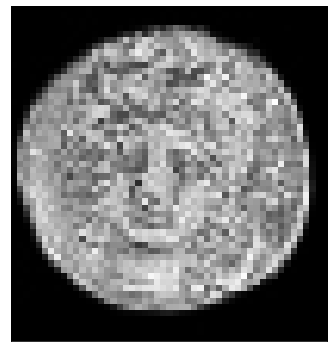

In [6]:
path = os.path.join(image_folder, "coin.jpg")
pattern = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(figsize=(5, 5), layout="tight")
show_image(ax, pattern, cmap="gray")

Для этого стандартизируем эти массивы данных и используем функцию [scipy.signal.correlate2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html), которая позволяет вычислить взаимнокорреляционную функцию двух двухмерных массивов.

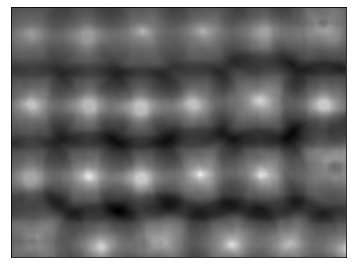

In [7]:
from scipy.signal import correlate2d
normalized_image = (image - image.mean()) / image.std()
normalized_pattern = (pattern - pattern.mean()) / pattern.std() 

correlation = correlate2d(normalized_image, normalized_pattern, mode="valid")

fig, ax = plt.subplots(figsize=(5, 5), layout="tight")
show_image(ax, correlation, cmap="gray")

Получили новое изображение. Его максимумы соответствуют максимальной корреляции изображения монеты с куском исходного изображения. 

Нарисуем прямоугольник размера монеты на месте самого большого значения.

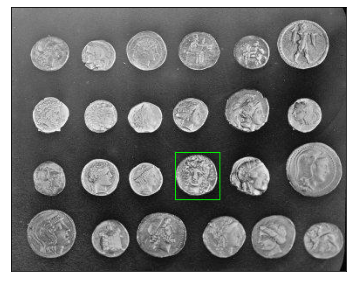

In [8]:
x, y = np.unravel_index(correlation.argmax(), correlation.shape)
h, w = pattern.shape

linewidth = 1
detected_coin = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
cv2.rectangle(detected_coin, (y, x), (y+w, x+h), green_color, linewidth)


fig, ax = plt.subplots(figsize=(5, 5), layout="tight")
show_image(ax, detected_coin, cmap="gray")

Возьмем 100 наибольших значения и нарисуем на их местах прямоугольники тоже.

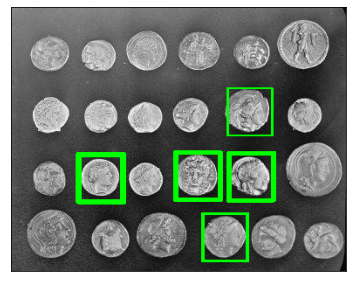

In [9]:
indexes = (-correlation).argsort(axis=None)[:100]

detected_coin = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
for index in indexes:
    x, y = np.unravel_index(index, correlation.shape)
    cv2.rectangle(detected_coin, (y, x), (y+w, x+h), green_color, linewidth)

fig, ax = plt.subplots(figsize=(5, 5), layout="tight")
show_image(ax, detected_coin, cmap="gray")

Многие прямоугольники оказались почти друг над другом, т.к. в рассматриваемой задаче небольшой сдвиг шаблона вносит малые изменения в коэффициент корреляции.

Чтобы решить эту проблему, отфильтруем все прямоугольники, которые располагаются друг к другу очень близко. Для этого в примере ниже реализована функция фильтрации прямоугольников `supression`, которая работает по следующему принципу:
1. Задаём пустой список `accepted` принятых алгоритмом прямоугольников;
2. Рассматриваем следующего кандидата в список принятых прямоугольников:
    1. Если `accepted` пуст, то добавляем этого кандидата в список;
    2. Иначе добавляем кандидата в список, только если он располагается на превышающем `min_dist` расстоянии от всех уже принятых прямоугольников из списка `accepted`.
3. Повторяем шаг 2 до тех пор, пока не наберется достаточное количество прямоугольников или кандидаты не исчерпаются. 

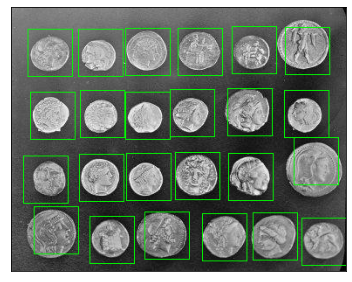

In [10]:
indexes = (-correlation).argsort(axis=None)


def compute_minimum_distance(point, points):
    if not points:
        return np.inf
    
    point, points = np.array([point]), np.array(points)
    diff = point - points
    distances = np.sqrt(np.sum(diff * diff, axis=1))
    return distances.min()


def supression(points, k, min_dist=30):
    accepted_points = []
    for point in points:
        d = compute_minimum_distance(point, accepted_points)
        if d > min_dist:
            accepted_points.append(point)
            if len(accepted_points) == k:
                return accepted_points
            
    return accepted_points


detected_coin = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
points = [np.unravel_index(index, correlation.shape) for index in indexes]
to_draw = supression(points, k=24)

for x, y in to_draw:
    cv2.rectangle(detected_coin, (y, x), (y+w, x+h), green_color, linewidth)

fig, ax = plt.subplots(figsize=(5, 5), layout="tight")
show_image(ax, detected_coin, cmap="gray")

## Извлечение признаков

Воспользуемся специальным методом [SIFT](https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D1%81%D1%88%D1%82%D0%B0%D0%B1%D0%BD%D0%BE-%D0%B8%D0%BD%D0%B2%D0%B0%D1%80%D0%B8%D0%B0%D0%BD%D1%82%D0%BD%D0%B0%D1%8F_%D1%82%D1%80%D0%B0%D0%BD%D1%81%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D1%8F_%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%BE%D0%B2), который позволяет находить на изображении такие признаки, которые можно относительно надежно находить на других изображениях того же объекта. Более конкретно этот метод находит на изображении ключевые точки и их дескрипторы (описания), которые позже можно сопоставить с таковыми на другом изображении и при хорошем совпадении считать, что объект обнаружен.

In [11]:
def SIFT_detection(image, pattern):
    orb = cv2.SIFT_create()
    key_points_1, descriptors_1 = orb.detectAndCompute(image, None)
    key_points_2, descriptors_2 = orb.detectAndCompute(pattern, None)

    FLANN_INDEX_KDTREE = 1
    index_params = {
        "algorithm": FLANN_INDEX_KDTREE,
        "trees": 5
    }
    search_params = {"checks": 50} 
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors_1, descriptors_2, k=2)
    
    matchesMask = [[0,0] for i in range(len(matches))]
    for i,(m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            matchesMask[i]=[1,0]
    
    draw_params = {
        "matchColor": (0, 255, 0),
        "singlePointColor": (255, 0, 0),
        "matchesMask": matchesMask, 
        "flags":  cv2.DrawMatchesFlags_DEFAULT
    }


    return cv2.drawMatchesKnn(
        image, 
        key_points_1, 
        pattern, 
        key_points_2, 
        matches, 
        None, 
        **draw_params
    )

    

Применим этот метод к нашим монетам.

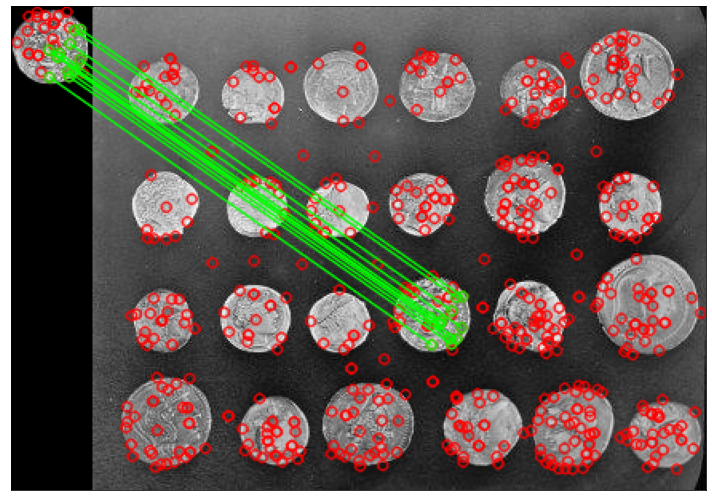

In [278]:
matches = SIFT_detection(pattern, image)

fig, ax = plt.subplots(figsize=(10, 10), layout="tight")
show_image(ax, matches, cmap="gray")

Этот метод имеет свои преимущества в случае, если искомый объект присутствует в изображении с несколько другим ракурсом.   

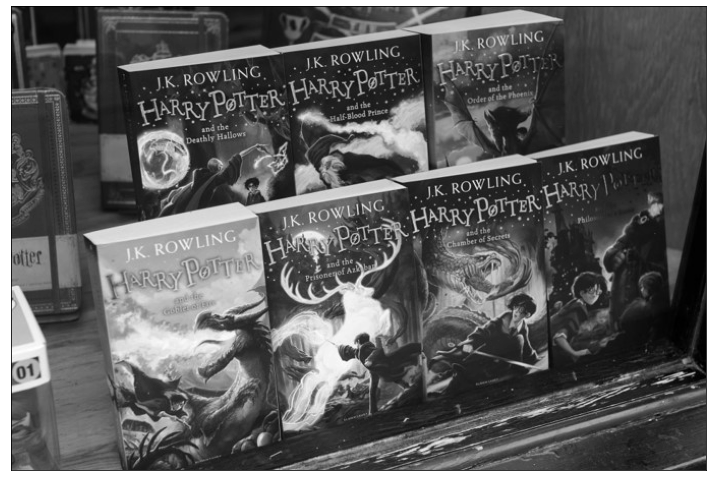

In [17]:
path = os.path.join(image_folder, "shelf.jpg")
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(figsize=(10, 10), layout="tight")
show_image(ax, image, cmap="gray")

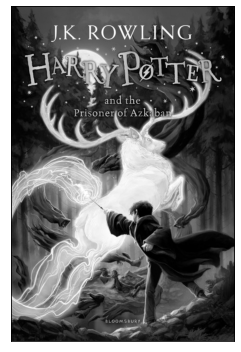

In [18]:
path = os.path.join(image_folder, "book.jpg")
pattern = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(figsize=(5, 5), layout="tight")
show_image(ax, pattern, cmap="gray")

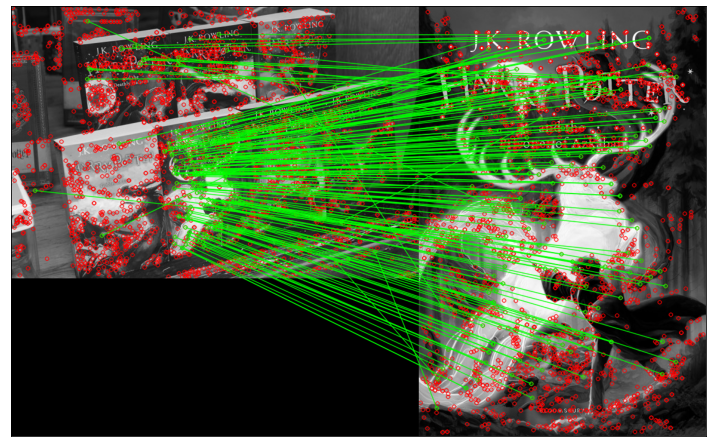

In [281]:
matches = SIFT_detection(image, pattern)

fig, ax = plt.subplots(figsize=(10, 10), layout="tight")
show_image(ax, matches, cmap="gray")